In [ ]:
import os 
import numpy as np
os.environ['KERAS_BACKEND'] = 'jax'
import keras
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
sns.set_palette("bright")
sns.set_style("whitegrid")


# Loading MedNIST data

In [2]:
#There is some code reuse here from other notebooks
#Data loading can be further simplified 

#Downloading MedNIST dataset
root_dir = "./"
dataset_url = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

downloaded_path = keras.utils.get_file(origin=dataset_url, file_hash=md5, hash_algorithm='md5', extract=True, cache_dir=root_dir)
path_to_downloaded_data = downloaded_path[:-7]
print(path_to_downloaded_data)

#Loading MedNIST dataset
train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(path_to_downloaded_data, validation_split=0.7, subset='both', \
                                       label_mode ='int', labels='inferred', color_mode='grayscale', seed=0, batch_size=128)
label_map = {int(idx):name for idx, name in enumerate(train_dataset.class_names)}
classes = train_dataset.class_names
print(classes)

./datasets/MedNIST
Found 58954 files belonging to 6 classes.
Using 17687 files for training.
Using 41267 files for validation.


2024-02-19 23:26:52.262539: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


In [3]:

#this is a quick implementation to create numpy array from image data
#more efficient conversion scheme can be implemented

#train images
images, labels = [], []

for images_batch, labels_batch in train_dataset:
    images.extend(images_batch.numpy())
    labels.extend(labels_batch.numpy())

train_data = np.array(images)
train_labels = np.array(labels)
train_num = train_data.shape[0]
train_data = train_data.reshape(train_num, -1)

#validation images
images, labels = [], []

for images_batch, labels_batch in validation_dataset:
    images.extend(images_batch.numpy())
    labels.extend(labels_batch.numpy())

validation_data = np.array(images)
validation_labels = np.array(labels)
validation_num = validation_data.shape[0]
validation_data = validation_data.reshape(validation_num, -1)

print(train_data.shape)
print(train_labels.shape)
print(validation_data.shape)
print(validation_labels.shape)
del images
del labels


(17687, 65536)
(17687,)
(41267, 65536)
(41267,)


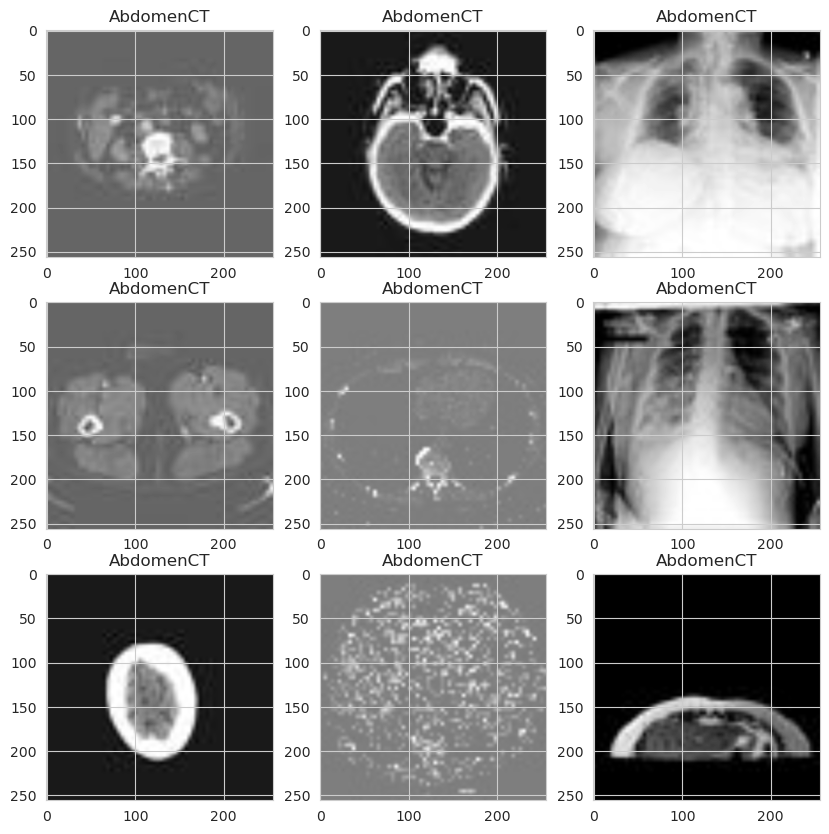

In [4]:
#Plotting images from the dataset
plt.subplots(3, 3, figsize=(10, 10))
for images, labels in train_dataset.take(1):

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.title(label_map[np.argmax(labels[i])])
        plt.imshow(np.array(images[i]), cmap='gray', vmin=0, vmax=255)
plt.show()

del train_dataset
del validation_dataset


# UMAP dimension reduction 

In [5]:

#UMAP on training data
t1 = time.time()
#without low_memory option, umap.fit() can take ~60GB RAM for this data split
mapper = umap.UMAP(n_components=2,n_neighbors=10, min_dist=0.05, low_memory=True).fit(train_data)
print(f"Time taken: {time.time() - t1} sec")

train_embed = mapper.transform(train_data)


Time taken: 48.127307415008545 sec


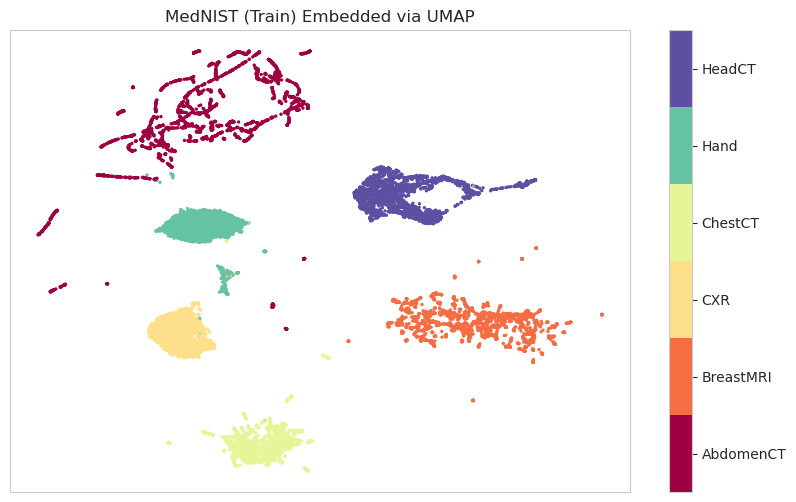

In [6]:
#Plotting the embedding

fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(train_embed[:,0], train_embed[:,1], s=2.0, c=train_labels, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('MedNIST (Train) Embedded via UMAP');
plt.show()

del train_embed
del mapper

# UMAP supervised with labels

In [7]:
t1 = time.time()
mapper = umap.UMAP(n_components=2, n_neighbors=10, low_memory=True).fit(train_data, y=train_labels)
print(f"Time taken: {time.time() - t1} sec")
train_embed = mapper.transform(train_data)
del train_data

Time taken: 42.14083123207092 sec


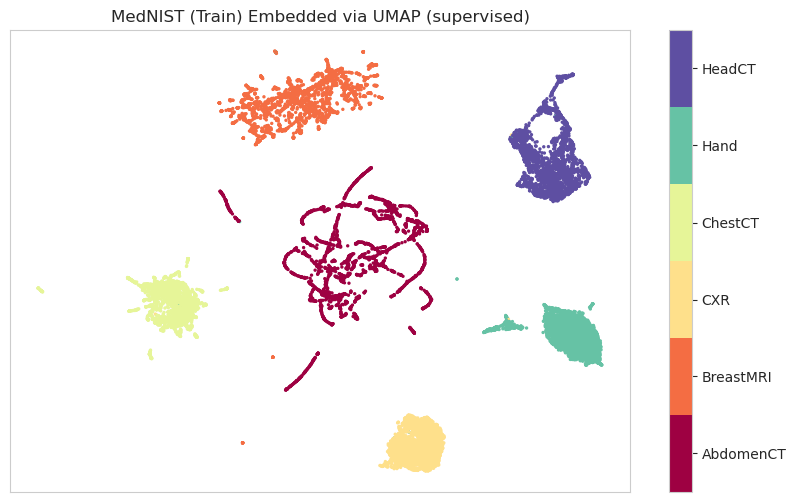

In [8]:
#Plotting the train_embed 
fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(train_embed[:,0], train_embed[:,1], s=2.0, c=train_labels, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('MedNIST (Train) Embedded via UMAP (supervised)');
plt.show()

In [9]:
#Embed validation data 
valid_embed = mapper.transform(validation_data)


/data1/sunil/miniconda3/envs/common_keras/lib/python3.11/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


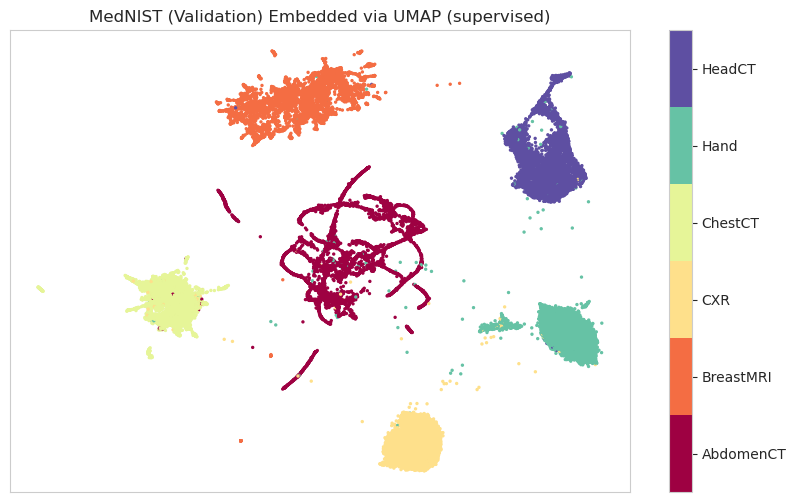

In [10]:
#Plotting the train_embed 
fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(valid_embed[:,0], valid_embed[:,1], s=2.0, c=validation_labels, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('MedNIST (Validation) Embedded via UMAP (supervised)');
plt.show()